### ARIMA 滚动预测-案例分析 
#### 1.数据读取

In [6]:
import numpy as np 
import pandas as pd 
from datetime import datetime
import matplotlib.pylab as plt 

# 读取数据, pd.read_csv 默认生成DataFrame 对象, 需要将其转成Series 对象
df = pd.read_csv('./data/AirPassengers.csv',encoding='utf-8',index_col='Month')
df.index = pd.to_datetime(df.index)  # 将字符串索引转换成时间索引
ts=df['Passengers'] # 生成pd.Series对象
# 查看数据格式
print(ts.head())
ts.head().index 


Month
1949-01-01    112
1949-02-01    118
1949-03-01    132
1949-04-01    129
1949-05-01    121
Name: Passengers, dtype: int64


DatetimeIndex(['1949-01-01', '1949-02-01', '1949-03-01', '1949-04-01',
               '1949-05-01'],
              dtype='datetime64[ns]', name='Month', freq=None)

In [7]:
#查看某一天的数据，直接用这一天的时间对象作为索引即可
ts['1949-01-01']

112

In [8]:
# 如果查看一年的时间， 直接用年即可
ts['1949']

Month
1949-01-01    112
1949-02-01    118
1949-03-01    132
1949-04-01    129
1949-05-01    121
1949-06-01    135
1949-07-01    148
1949-08-01    148
1949-09-01    136
1949-10-01    119
1949-11-01    104
1949-12-01    118
Name: Passengers, dtype: int64

In [9]:
# 时间切片
ts['1949-1':'1949-6']

Month
1949-01-01    112
1949-02-01    118
1949-03-01    132
1949-04-01    129
1949-05-01    121
1949-06-01    135
Name: Passengers, dtype: int64

In [30]:
# 平稳性检验: 观察法和单位根检验法
# -*- coding:utf-8 -*- 
from statsmodels.tsa.stattools import adfuller 
import pandas as pd 
import matplotlib.pyplot as plt 
import numpy as np 
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf 

# 移动平均
def draw_trend(timeSeries, size):
    f = plt.figure(facecolor='white',figsize=(12,8))
    # 对size个数据进行移动平均
    rol_mean = timeSeries.rolling(window=size).mean() 
    # 对size个数据进行加权移动平均
    rol_weighted_mean = pd.DataFrame.ewm(timeSeries, span=size).mean()
    timeSeries.plot(color='blue', label='Original')
    rol_mean.plot(color='red',label='Rolling Mean')
    rol_weighted_mean.plot(color='black',label='Weighted Rolling Mean')
    plt.legend(loc='best')
    plt.title('Rolling Mean')
    plt.show() 
    
def draw_ts(timeSeries):
    f = plt.figure(facecolor='white',figsize=(12,8))
    timeSeries.plot(color='blue')
    plt.show() 
    
'''
    Unit Root Test 
    The null hypothesis of the Augmented Dickey-Fuller is that there is a unit root, with the alternative that there is no unit root. 
    That is to say the bigger the p-value the more reason we assert that there is a unit root 
'''

def testStationarity(ts):
    dftest = adfuller(ts)
    # 对上述函数求得的值进行语义描述
    dfoutput=pd.Series(dftest[0:4],index=['Test Statistic','p-value','#Lags Used', 'Number of Observations Used'])
    for key, value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] =value 
    return dfoutput 

# 自相关和偏自相关图，默认阶数为31阶
def draw_acf_pacf(ts, lags=31):
    f = plt.figure(facecolor='white',figsize=(12,8))
    ax1 = f.add_subplot(211)
    plot_acf(ts, lags=31, ax=ax1)
    ax2 = f.add_subplot(212)
    plot_pacf(ts, lags=31, ax=ax2)
    plt.show()

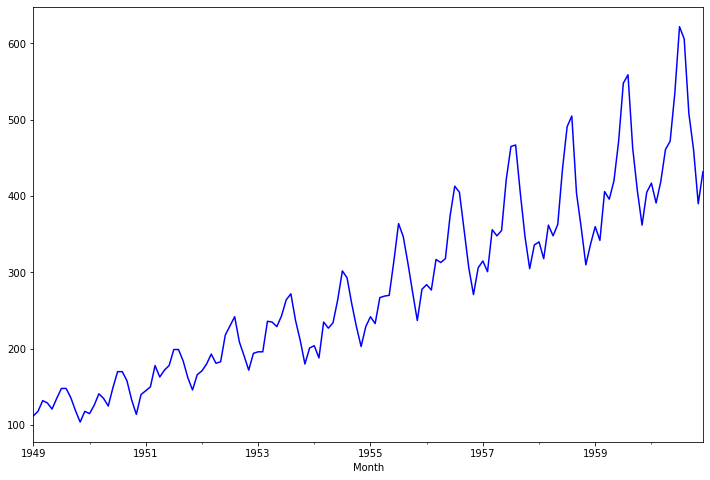

In [14]:
draw_ts(ts)

/opt/anaconda3/lib/python3.8/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


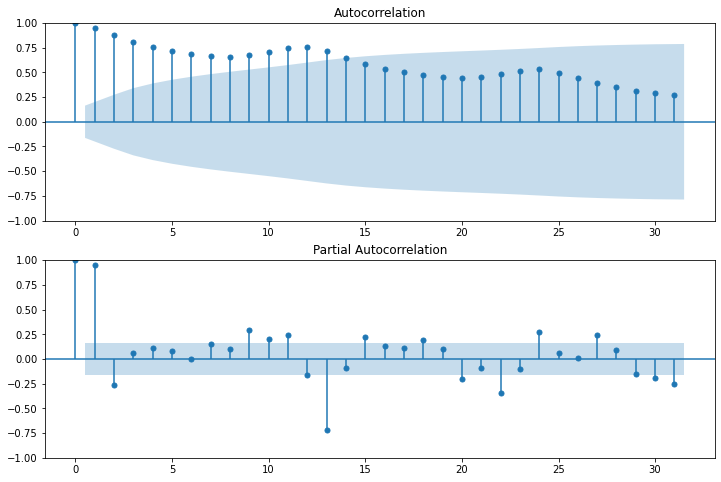

In [15]:
draw_acf_pacf(ts)

#### 观察法
观察法，通俗的说就是通过观察序列的趋势图与相关图是否随着时间的变化呈现出某种规律。所谓的规律就是时间序列经常提到的周期性因素，现实中遇到得比较多的是线性周期成分，这类周期成分可以采用差分或者移动平均来解决，而对于非线性周期成分的处理相对比较复杂，需要采用某些分解的方法。下图为航空数据的线性图，可以明显的看出它具有年周期成分和长期趋势成分。平稳序列的自相关系数会快速衰减，上面的自相关图并不能体现出该特征，所以我们有理由相信该序列是不平稳的。


#### 单位根检验
单位根检验：ADF是一种常用的单位根检验方法，他的原假设为序列具有单位根，即非平稳，对于一个平稳的时序数据，就需要在给定的置信水平上显著，拒绝原假设。ADF只是单位根检验的方法之一，如果想采用其他检验方法，可以安装第三方包arch，里面提供了更加全面的单位根检验方法，个人还是比较钟情ADF检验。以下为检验结果，其p值大于0.99，说明并不能拒绝原假设。 即原假设时间序列为非平稳成立


In [16]:
testStationarity(ts)

Test Statistic                   0.815369
p-value                          0.991880
#Lags Used                      13.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64

#### 平稳性处理
平稳性是时间序列分析的前提条件 

a.对数变换 

对数变换主要是为了减小数据的振动幅度，使其线性规律更加明显（我是这么理解的时间序列模型大部分都是线性的，为了尽量降低非线性的因素，需要对其进行预处理，也许我理解的不对）。对数变换相当于增加了一个惩罚机制，数据越大其惩罚越大，数据越小惩罚越小。这里强调一下，变换的序列需要满足大于0，小于0的数据不存在对数变换。


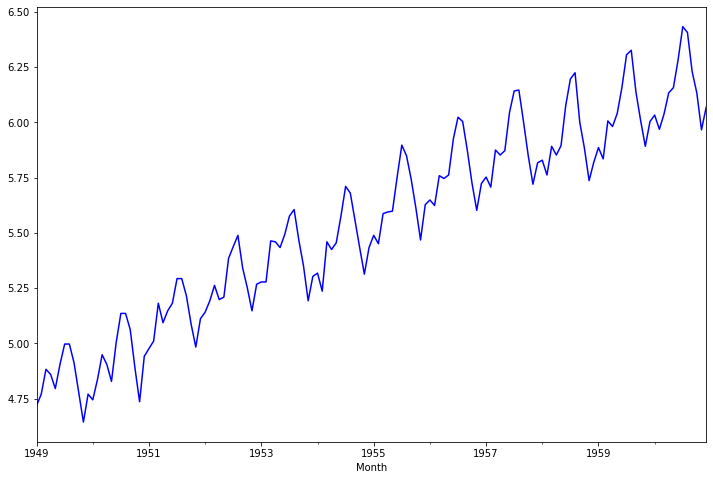

In [19]:
ts_log = np.log(ts)
draw_ts(ts_log)

b.平滑法  

根据平滑技术的不同， 平滑法具体分为移动平均法和指数平均法  
移动平均即利用一定时间间隔内的平均值作为某一期的估计值，而指数平均则是用变权的方法来计算均值 

从下图可以发现窗口为12的移动平均能较好的剔除年周期性因素，而指数平均法是对周期内的数据进行了加权，能在一定程度上减小年周期因素，但并不能完全剔除，如要完全剔除可以进一步进行差分操作。

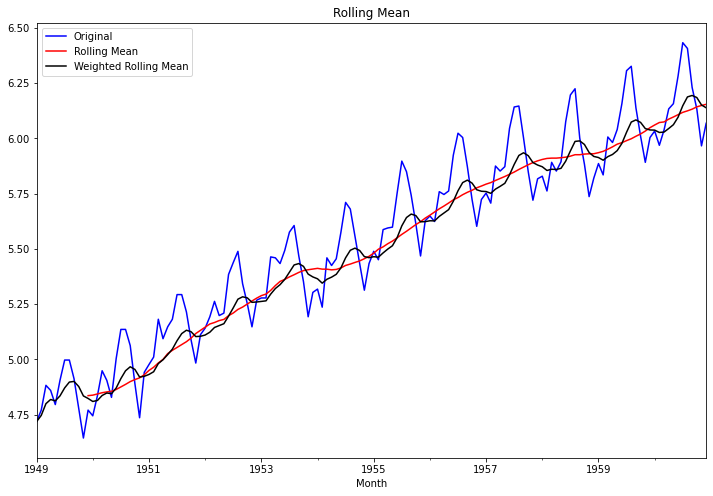

In [31]:
draw_trend(ts_log, 12)

#### c.差分
时间序列最常用来剔除周期性因素的方法当属差分了，它主要是对等周期间隔的数据进行线性求减。前面我们说过，ARIMA模型相对ARMA模型，仅多了差分操作，ARIMA模型几乎是所有时间序列软件都支持的，差分的实现与还原都非常方便。而statsmodel中，对差分的支持不是很好，它不支持高阶和多阶差分，为什么不支持，作者大概的意思是说预测方法中并没有解决高于2阶的差分，有没有感觉很牵强，不过没关系，我们有pandas。我们可以先用pandas将序列差分好，然后在对差分好的序列进行ARIMA拟合，只不过这样后面会多了一步人工还原的工作。


In [32]:
diff_12 = ts_log.diff(12)
diff_12.dropna(inplace=True)
diff_12_1 = diff_12.diff(1)
diff_12_1.dropna(inplace=True)
testStationarity(diff_12_1)

Test Statistic                  -4.443325
p-value                          0.000249
#Lags Used                      12.000000
Number of Observations Used    118.000000
Critical Value (1%)             -3.487022
Critical Value (5%)             -2.886363
Critical Value (10%)            -2.580009
dtype: float64

In [33]:
diff_13 = ts_log.diff(13)
diff_13.dropna(inplace=True)
testStationarity(diff_13)

Test Statistic                  -2.780749
p-value                          0.061077
#Lags Used                      12.000000
Number of Observations Used    118.000000
Critical Value (1%)             -3.487022
Critical Value (5%)             -2.886363
Critical Value (10%)            -2.580009
dtype: float64

#### d.分解
所谓分解就是将时序数据分离成不同的成分。statsmodels使用的X-11分解过程，它主要将时序数据分离成长期趋势、季节趋势和随机成分。与其它统计软件一样，statsmodels也支持两类分解模型，加法模型和乘法模型，这里我只实现加法，乘法只需将model的参数设置为"multiplicative"即可。


In [79]:
def draw_decompose(ts_log, trend, seasonal, residual):
    plt.figure(facecolor='white',figsize=(16,10))
    plt.subplots_adjust(wspace=0.7,hspace=0.5)
    plt.subplot(411)
    plt.plot(ts_log,color='b')
    plt.legend(['Original'])
    plt.subplot(412)
    plt.plot(trend,color='b')
    plt.legend(['Trend'])
    plt.subplot(413)
    plt.plot(seasonal,color='b')
    plt.legend(['seasonal'])
    plt.subplot(414)
    plt.plot(residual,color='b')
    plt.legend(['residual'])

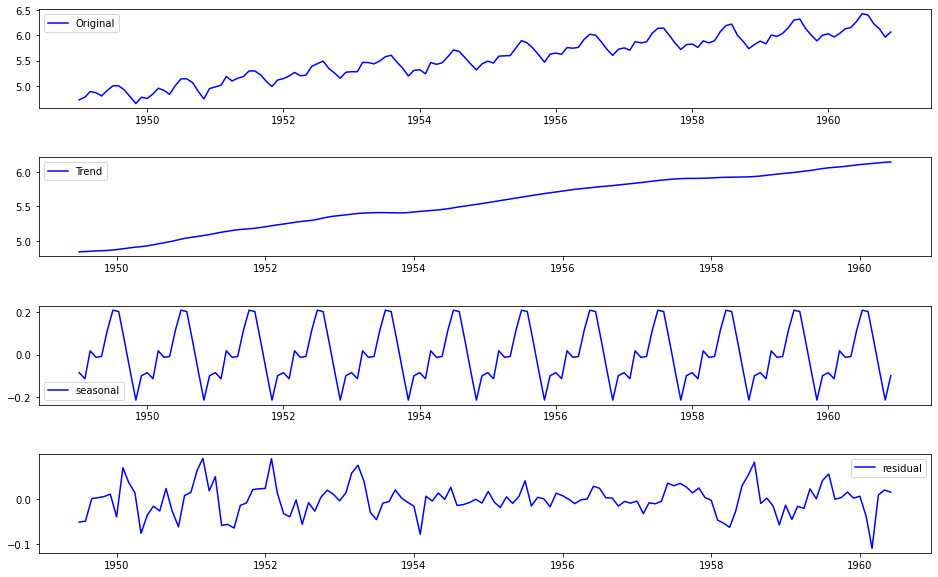

In [80]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log, model='additive')
trend = decomposition.trend 
seasonal = decomposition.seasonal
residual = decomposition.resid
draw_decompose(ts_log, trend, seasonal,residual)


得到不同的分解成分后，就可以使用时间序列模型对各个成分进行拟合，当然也可以选择其他预测方法。我曾经用过小波对时序数据进行过分解，然后分别采用时间序列拟合，效果还不错。由于我对小波的理解不是很好，只能简单的调用接口，如果有谁对小波、傅里叶、卡尔曼理解得比较透，可以将时序数据进行更加准确的分解，由于分解后的时序数据避免了他们在建模时的交叉影响，所以我相信它将有助于预测准确性的提高。


#### 4.模型识别
在前面的分析可知，该序列具有明显的年周期与长期成分。对于年周期成分我们使用窗口为12的移动平进行处理，对于长期趋势成分我们采用1阶差分来进行处理。

In [39]:
rol_mean = ts_log.rolling(window=12).mean() 
rol_mean.dropna(inplace=True)
ts_diff_1 = rol_mean.diff(1)
ts_diff_1.dropna(inplace=True)
testStationarity(ts_diff_1)

Test Statistic                  -2.709577
p-value                          0.072396
#Lags Used                      12.000000
Number of Observations Used    119.000000
Critical Value (1%)             -3.486535
Critical Value (5%)             -2.886151
Critical Value (10%)            -2.579896
dtype: float64

观察其统计量发现该序列在置信水平为95%的区间下并不显著，我们对其进行再次一阶差分。再次差分后的序列其自相关具有快速衰减的特点，t统计量在99%的置信水平下是显著的，这里我不再做详细说明

In [81]:
ts_diff_2 = ts_diff_1.diff(1)
ts_diff_2.dropna(inplace=True)

数据平稳后，需要对模型定阶，即确定p、q的阶数。观察上图，发现自相关和偏相系数都存在拖尾的特点，并且他们都具有明显的一阶相关性，所以我们设定p=1, q=1。下面就可以使用ARMA模型进行数据拟合了。这里我不使用ARIMA(ts_diff_1, order=(1, 1, 1))进行拟合，是因为含有差分操作时，预测结果还原老出问题，至今还没弄明白。


/opt/anaconda3/lib/python3.8/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


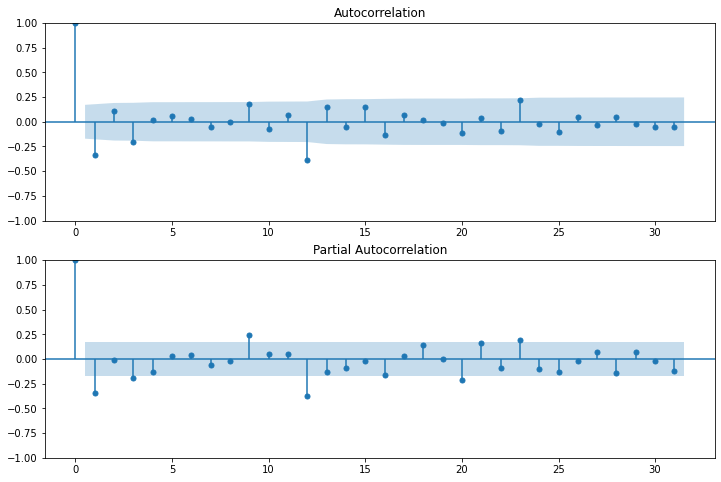

In [82]:
draw_acf_pacf(ts_diff_2)

数据平稳后，需要对模型定阶，即确定p、q的阶数。观察上图，发现自相关和偏相系数都存在拖尾的特点，并且他们都具有明显的一阶相关性，所以我们设定p=1, q=1。下面就可以使用ARMA模型进行数据拟合了。这里我不使用ARIMA(ts_diff_1, order=(1, 1, 1))进行拟合，是因为含有差分操作时，预测结果还原老出问题，至今还没弄明白。

#### 5.样本拟合
模型拟合完后，我们就可以对其进行预测了。由于ARMA拟合的是经过相关预处理后的数据，故其预测值需要通过相关逆变换进行还原。


In [ ]:
# -*-coding:utf-8 -*-
import pandas as pd 
import numpy as 
from statsmodels.tsa.arima_model import ARMA